In [48]:
import pandas as pd
import keras
import os
from data_loading import load_tracking_data
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from scipy import spatial
import numpy as np
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from utility_db_25 import mark_columns, TrainML
from utility_db_25 import mark_columns, TrainML, get_momentum_cols, create_momentum_index, get_motion_cols, motion_complexity_score
root_dir = os.getcwd()

# Load data

We first load our data, starting with tracking & general player data

In [49]:
# load tracking data for all weeks
root_dir = os.getcwd()
tracking_fname_list = [os.path.join(root_dir,  f"data/tracking_week_{i}.csv") for i in range(1,10)]
df_tracking = pd.concat(
        [load_tracking_data(tracking_fname) for tracking_fname in tracking_fname_list]
    )

# get players data
df_players = pd.read_csv(os.path.join(root_dir,'data/players.csv'))

# load tracking, truncate to relevant columns, delete
cols_track = ['gameId','playId','nflId','frameId','club','x_standard','y_standard', 'dis', 'dir_standard']
track_trunc = df_tracking[cols_track]
del(df_tracking)

In [50]:
#track_trunc=pd.read_csv('data/tracking_trunc.csv')
df_games = pd.read_csv('data/games.csv')[[
    'gameId','week'
]].drop_duplicates()
track_trunc=pd.merge(track_trunc, df_games, on='gameId', how='inner')

### Merge onto play level

Note: some plays (38?) lack defensive tracking data, ergo losing some plays to dropping NA's 


In [51]:
# merge  tracking info to play-level data
df_plays = pd.read_csv(os.path.join(root_dir,'data/plays.csv'))
play_trunc = df_plays[['gameId','playId','possessionTeam','isDropback']]
pt_df = pd.merge(track_trunc,play_trunc, how='left',right_on=['gameId','playId','possessionTeam'],
                 left_on=['gameId','playId','club'])

# na's dropped to lose players w/o tracking info
def_df = pt_df.dropna().copy()
def_df.head(3)

,gameId,playId,nflId,frameId,club,x_standard,y_standard,dis,dir_standard,week,possessionTeam,isDropback
112,2022091200,64,39987.0,2,SEA,33.95,23.50,0.04,19.89,1,SEA,False
113,2022091200,64,39987.0,3,SEA,33.96,23.54,0.04,19.91,1,SEA,False
114,2022091200,64,39987.0,4,SEA,33.98,23.58,0.05,24.17,1,SEA,False


In [52]:
# get position here for calcs
df_players = pd.read_csv(os.path.join(root_dir,'data/players.csv'))
def_temp = def_df.merge(df_players[['nflId','position']],how='left',copy=False)
def_temp.sort_values(by=['gameId','playId','frameId'],inplace=True)
del(track_trunc)
del(df_players)
def_temp.head()
def_temp.drop(columns='week', inplace=True)

In [53]:

ci = pd.merge(def_temp[['gameId','playId']].drop_duplicates(), pd.Series(list(range(1,101))).rename('frameId'), how='cross',copy=False).sort_values(by=['gameId','playId','frameId'])
ci=pd.merge(df_games, ci, on=['gameId'])[['gameId', 'playId', 'frameId', 'week']]
ci_merged = pd.merge(ci, def_temp,on=['gameId', 'playId', 'frameId'],how='left',copy=False)[['gameId', 'playId', 'frameId', 'week']].drop_duplicates()

In [54]:
len(ci)

1608600

In [55]:
len(def_temp)

18371122

In [56]:
len(ci_merged)

1608600

In [57]:
off_positions=['WR','T','G', 'TE',  'RB','FB', 'C', 'QB']
for p in off_positions:
    df=def_temp[def_temp['position']==p][['gameId', 'playId', 'frameId','dir_standard', 'dis', 'x_standard', 'y_standard']].groupby(['gameId', 'playId', 'frameId']).agg({'dir_standard': 'mean', 'dis':'sum', 'x_standard':'mean', 'y_standard':'mean'}).reset_index().copy()
    df.columns = ['gameId', 'playId', 'frameId',p+'_dir', p+'_dis', p+'x_standard', p+'y_standard']
    ci_merged=ci_merged.merge(df,how='left',on=['gameId','playId','frameId'])
    del(df)
ci_merged.fillna(0, inplace=True)

In [58]:
ci_merged.sample(10)

,gameId,playId,frameId,week,WR_dir,WR_dis,WRx_standard,WRy_standard,T_dir,T_dis,...,FBx_standard,FBy_standard,C_dir,C_dis,Cx_standard,Cy_standard,QB_dir,QB_dis,QBx_standard,QBy_standard
1563714,2022110608,1141,15,9,171.940000,0.47,18.570000,17.338333,106.890,0.10,...,0.00,0.000000,201.335,0.03,21.205,28.623333,139.56,0.03,16.93,29.823333
30485,2022091101,2452,86,1,157.823333,0.05,58.666667,27.986667,179.690,0.02,...,0.00,0.000000,243.270,0.02,59.230,24.340000,87.62,0.00,55.44,24.030000
267965,2022091805,465,66,2,6.633333,0.65,78.680000,32.000000,42.615,0.07,...,0.00,0.000000,261.240,0.03,80.180,23.770000,82.18,0.01,78.79,23.510000
1154945,2022102302,2537,46,7,203.030000,0.01,36.345000,22.623333,161.680,0.01,...,32.87,29.153333,210.690,0.00,36.970,26.513333,338.76,0.00,32.59,26.283333
864120,2022100908,1372,21,5,83.215000,0.89,52.275000,23.538333,103.705,0.14,...,0.00,0.000000,84.680,0.01,56.120,23.553333,71.84,0.03,51.27,23.613333
945951,2022101300,760,52,6,137.136667,0.00,37.603333,23.400000,247.740,0.00,...,0.00,0.000000,348.890,0.00,38.330,29.563333,118.14,0.00,34.29,29.773333
807394,2022100903,1693,95,5,220.840000,0.01,88.160000,38.648333,291.155,0.02,...,0.00,0.000000,351.510,0.00,88.780,23.243333,130.47,0.02,84.74,23.393333
542593,2022092512,2174,94,3,317.313333,0.02,10.243333,22.543333,171.240,0.00,...,0.00,0.000000,20.480,0.00,11.380,29.873333,271.66,0.02,6.40,30.053333
1059173,2022101608,2754,74,6,74.783333,0.05,65.733333,27.410000,84.415,0.03,...,0.00,0.000000,0.000,0.00,0.000,0.000000,167.22,0.01,65.89,29.910000
1312745,2022103001,2866,46,8,115.960000,0.26,103.455000,29.365000,115.915,0.07,...,0.00,0.000000,118.240,0.01,104.400,29.570000,165.17,0.02,103.39,29.620000


In [59]:

def calculate_distance(row):
    x1, y1 = row['RBx_standard'], row['RBy_standard']
    x2, y2 = row['QBx_standard'], row['QBy_standard']
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)


ci_merged['RBdistance'] = ci_merged.apply(calculate_distance, axis=1)

def calculate_distance(row):
    x1, y1 = row['Gx_standard'], row['Gy_standard']
    x2, y2 = row['QBx_standard'], row['QBy_standard']
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
ci_merged['Gdistance'] = ci_merged.apply(calculate_distance, axis=1)


def calculate_distance(row):
    x1, y1 = row['Cx_standard'], row['Cy_standard']
    x2, y2 = row['QBx_standard'], row['QBy_standard']
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
ci_merged['Cdistance'] = ci_merged.apply(calculate_distance, axis=1)
def calculate_distance(row):
    x1, y1 = row['TEx_standard'], row['TEy_standard']
    x2, y2 = row['QBx_standard'], row['QBy_standard']
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
ci_merged['TEdistance'] = ci_merged.apply(calculate_distance, axis=1)


In [60]:
# merge back in

db_df = def_df[['gameId','playId','isDropback']].drop_duplicates()
ci_pre = ci_merged.merge(db_df,how='left')
del(ci_merged)
#del(def_df)
ci_pre=ci_pre[ci_pre['week']>0]

In [61]:
ci_pre.week.max()

9

In [62]:
len(ci_pre)/100

16086.0

### Perform train/test split

We integrate week data, then subset based on week 9 holdout:

In [63]:
# subset week
df_train = ci_pre[(ci_pre['week'] <9.0) ].drop_duplicates()
df_test = ci_pre[ci_pre['week'] ==9.0].drop_duplicates()

# y = isDropback
y_train = df_train['isDropback'].astype(int)
y_test = df_test['isDropback'].astype(int)

In [64]:
len(df_train)/100

14556.0

In [65]:
len(df_train[['gameId','playId']].drop_duplicates())

14556

In [66]:
df_train.fillna(0, inplace=True)

In [67]:
len(df_train.drop(columns=['gameId', 'playId', 'frameId', 'week', 'isDropback']).columns)

36

In [68]:
# define scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# scale

In [69]:
# load original data
train_data=pd.read_csv(os.path.join(root_dir, "data/train_data.csv"))
test_data=pd.read_csv(os.path.join(root_dir, "data/test_data.csv"))
train_motion_cols=get_motion_cols(train_data.columns)
train_momentum_cols=get_momentum_cols(train_data.columns)

test_motion_cols=get_motion_cols(test_data.columns)
test_momentum_cols=get_momentum_cols(test_data.columns)


train_data=create_momentum_index(train_data, train_momentum_cols)
test_data=create_momentum_index(test_data, test_momentum_cols)

train_data=motion_complexity_score(train_data, test_motion_cols)
test_data=motion_complexity_score(test_data, test_motion_cols)
final_features=['gameId', 'playId', 'xpass_situational', 'yardsToGo', 'down',  'neg_alignment','absoluteYardlineNumber','time_remaining','quarter',
 'neg_Formations',
 'off_xpass',
 'QBdffy_RB',
 'presnap_motion_complexity',
 'presnap_momentum',
 'receiverAlignment_3x2', 
 'QBdff_WR']
df_train=pd.merge(df_train, train_data[final_features], on=['gameId', 'playId'], how='inner')
df_test=pd.merge(df_test, test_data[final_features], on=['gameId', 'playId'], how='inner')


In [70]:
df_test.sort_values(by='QBy_standard',ascending=False)

,gameId,playId,frameId,week,WR_dir,WR_dis,WRx_standard,WRy_standard,T_dir,T_dis,...,absoluteYardlineNumber,time_remaining,quarter,neg_Formations,off_xpass,QBdffy_RB,presnap_motion_complexity,presnap_momentum,receiverAlignment_3x2,QBdff_WR
105170,2022110608,193,71,9,61.20,0.01,73.45,14.143333,191.430,0.00,...,45,57.350000,1,0,0.553442,10.810545,0.0,0.0,1,74.617683
105178,2022110608,193,79,9,46.94,0.00,73.43,14.133333,151.035,0.00,...,45,57.350000,1,0,0.553442,10.810545,0.0,0.0,1,74.617683
105147,2022110608,193,48,9,144.19,0.01,73.41,14.093333,124.650,0.02,...,45,57.350000,1,0,0.553442,10.810545,0.0,0.0,1,74.617683
105148,2022110608,193,49,9,140.33,0.01,73.41,14.103333,129.635,0.02,...,45,57.350000,1,0,0.553442,10.810545,0.0,0.0,1,74.617683
105173,2022110608,193,74,9,48.07,0.01,73.44,14.143333,183.570,0.00,...,45,57.350000,1,0,0.553442,10.810545,0.0,0.0,1,74.617683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89075,2022110606,2376,76,9,0.00,0.00,0.00,0.000000,0.000,0.00,...,29,20.500000,3,0,0.640214,12.997711,0.0,1.0,0,101.945134
89076,2022110606,2376,77,9,0.00,0.00,0.00,0.000000,0.000,0.00,...,29,20.500000,3,0,0.640214,12.997711,0.0,1.0,0,101.945134
89077,2022110606,2376,78,9,0.00,0.00,0.00,0.000000,0.000,0.00,...,29,20.500000,3,0,0.640214,12.997711,0.0,1.0,0,101.945134
89078,2022110606,2376,79,9,0.00,0.00,0.00,0.000000,0.000,0.00,...,29,20.500000,3,0,0.640214,12.997711,0.0,1.0,0,101.945134


In [71]:
df_train.columns.values

array(['gameId', 'playId', 'frameId', 'week', 'WR_dir', 'WR_dis',
       'WRx_standard', 'WRy_standard', 'T_dir', 'T_dis', 'Tx_standard',
       'Ty_standard', 'G_dir', 'G_dis', 'Gx_standard', 'Gy_standard',
       'TE_dir', 'TE_dis', 'TEx_standard', 'TEy_standard', 'RB_dir',
       'RB_dis', 'RBx_standard', 'RBy_standard', 'FB_dir', 'FB_dis',
       'FBx_standard', 'FBy_standard', 'C_dir', 'C_dis', 'Cx_standard',
       'Cy_standard', 'QB_dir', 'QB_dis', 'QBx_standard', 'QBy_standard',
       'RBdistance', 'Gdistance', 'Cdistance', 'TEdistance', 'isDropback',
       'xpass_situational', 'yardsToGo', 'down', 'neg_alignment',
       'absoluteYardlineNumber', 'time_remaining', 'quarter',
       'neg_Formations', 'off_xpass', 'QBdffy_RB',
       'presnap_motion_complexity', 'presnap_momentum',
       'receiverAlignment_3x2', 'QBdff_WR'], dtype=object)

In [72]:
final_features=[  'RBdistance','Gdistance','TEdistance',
       'off_xpass', 'TEx_standard', 'TEy_standard', 
      'RBy_standard',  'yardsToGo', 'down', 'absoluteYardlineNumber','time_remaining', 'Cx_standard',
       'Cy_standard', 'neg_Formations',  'QBdffy_RB',
       'presnap_motion_complexity','presnap_momentum', 'receiverAlignment_3x2']

In [73]:
len(final_features)

18

In [74]:
X_train=df_train[final_features]
X_test=df_test[final_features]


In [75]:
X_test.isna().sum()

RBdistance                   0
Gdistance                    0
TEdistance                   0
off_xpass                    0
TEx_standard                 0
TEy_standard                 0
RBy_standard                 0
yardsToGo                    0
down                         0
absoluteYardlineNumber       0
time_remaining               0
Cx_standard                  0
Cy_standard                  0
neg_Formations               0
QBdffy_RB                    0
presnap_motion_complexity    0
presnap_momentum             0
receiverAlignment_3x2        0
dtype: int64

Training Folds: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

Mean Train AUC --> 0.8013
Mean Validation AUC ---> 0.8004
Mean Train Accuracy --> 0.8158
Mean Validation Accuracy ---> 0.8149


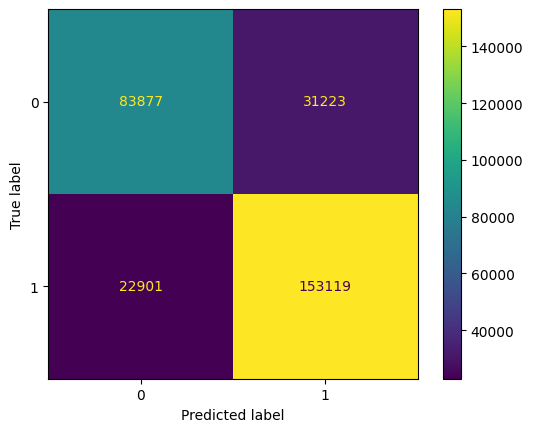

In [76]:
#lgbm classifier
scaler = MinMaxScaler(feature_range=(0, 1))
pipeline=Pipeline([('tr', scaler), ('lgbm', LGBMClassifier(verbosity=-1))], verbose = True)
lgb = LGBMClassifier(verbosity=-1,seed=42).fit(X_train,y_train)
TrainML(pipeline,X_train, y_train,5,SEED=42)

In [77]:
pipeline.fit(X_train, y_train)
y_preds=pipeline.predict(X_test)
y_prob=pipeline.predict_proba(X_test)[:,1]

[Pipeline] ................ (step 1 of 2) Processing tr, total=   0.3s
[Pipeline] .............. (step 2 of 2) Processing lgbm, total=   2.4s


c:\ProgramData\Anaconda3\envs\bdb2025-env\lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


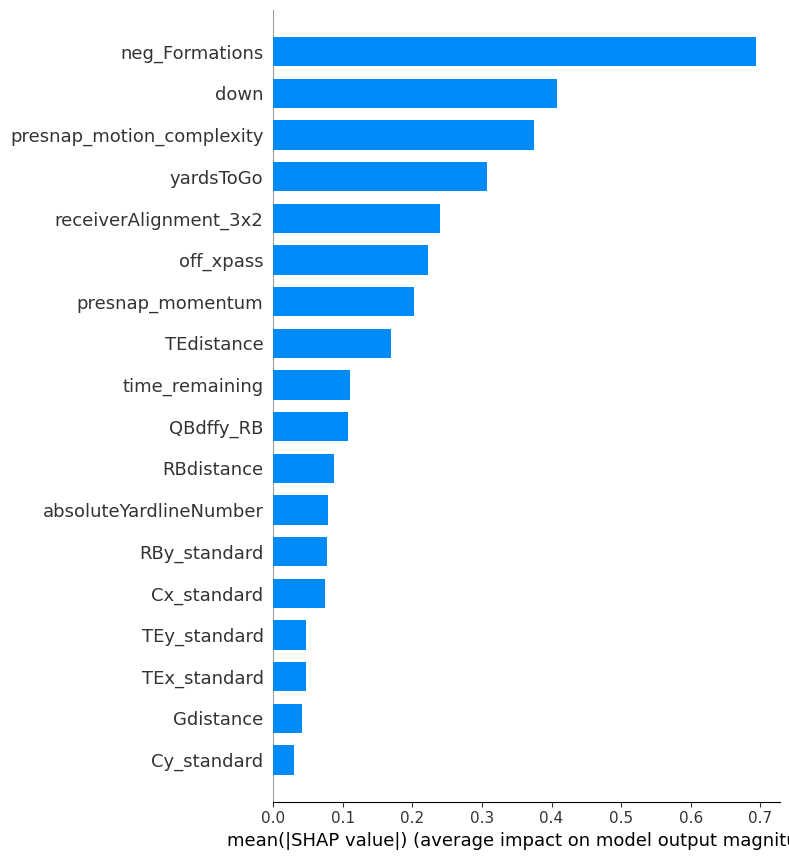

In [78]:
import shap 
shap_values = shap.TreeExplainer(lgb).shap_values(X_test)
shap.summary_plot(shap_values, X_train, plot_type="bar")
feature_names = final_features


lgbm_resultX = pd.DataFrame(shap_values, columns = feature_names)

vals = np.abs(lgbm_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)


In [79]:
y_prob

array([0.54816282, 0.52729419, 0.52729419, ..., 0.65135356, 0.65135356,
       0.65135356])

In [80]:

reshaped_data = y_preds.reshape((int(len(y_preds)/100), 100, ))


In [81]:
len(y_preds)

153000

In [82]:
predictions=[]
for i in reshaped_data:
    predictions.append(i.max())
predictions

[1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,


In [83]:
y_true=test_data['pass']

In [84]:
accuracy_score(y_true, predictions)

0.8143790849673203

In [85]:
#df_test[df_test['xpass_situational']<.2]

In [86]:
df_test['predictions'] = y_prob

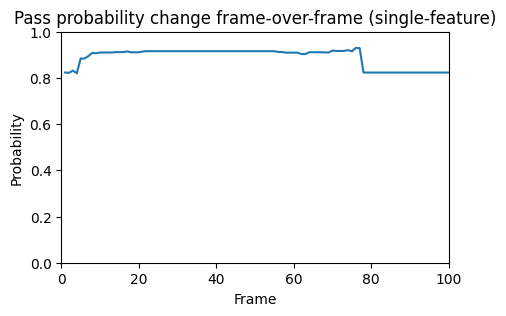

In [87]:
example=df_test[(df_test['gameId']==2022110600)& (df_test['playId']==326)][['frameId', 'predictions']]
plt.figure(figsize=(5,3))
plt.title('Pass probability change frame-over-frame (single-feature)')
plt.xlabel('Frame')
plt.ylabel('Probability')
plt.plot(example['frameId'],example['predictions'])
plt.ylim(0, 1)
plt.xlim(0,100)
plt.show()